In [1]:
import pickle
from datetime import datetime as dt
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
day = dt.today().day
month = dt.today().month
year = dt.today().year

dt_str = os.path.join('.', 'reddit_data_{}-{}-{}'.format(month, day, year) )

df = pd.read_pickle(dt_str)

# Clean Up the Data
#### Extract some features, remove any columns that aren't informative

In [3]:
def handle_unique_columns(df):
    '''Format and build features on a case-by-case basis'''
    
    num_gilds = df['gold_awarded'] + df['platinum_awarded']
    gilded = num_gilds.apply(lambda x: 1 if x > 0 else 0)
    
    weekday = df['created_utc'].apply(lambda x: dt.utcfromtimestamp(x).weekday() )
    hour = df['created_utc'].apply(lambda x: dt.utcfromtimestamp(x).hour )
    
    scrape_time = [ID[-4:] for ID in df['id']]
    
    return gilded, weekday, hour, scrape_time

new_cols = handle_unique_columns(df)

df['gilded']           = new_cols[0]
df['weekday']          = new_cols[1]
df['post_hour']        = new_cols[2]
df['scrape_time']      = new_cols[3]

In [4]:
def get_all_useless_cols(df):
    '''Remove listed columns as well as any other columms with cardinality 1'''
    useless_cols = ['author', 'id', 'created_utc', 
                    'silver_awarded', 'gold_awarded', 'platinum_awarded',
                   'post_time',]
    for col in df.columns:
        try:
            num_unique_entries = len(df[col].unique())
            if num_unique_entries == 1:
                useless_cols.append(col)
        except:
            pass
        
    return useless_cols

df.drop(columns = get_all_useless_cols(df), inplace = True)

#### Distinguish between categorical and numeric data

In [5]:
categ_feats = ['title', 'contest_mode','edited', 'adult_content', 'oc','content_categories',
               'reddit_media', 'selfpost', 'video', 'subreddit', 'how_sorted', 'weekday', 
                'post_hour', 'distinguished', 'scrape_time'
              ]

numeric_feats = ['upvotes', 'upvote_ratio', 'crossposts',
                 'comments', 'post_age', 'upvote_rate',  'comment_rate', 
                 'avg_up_rate', 'std_up_rate', 'gild_rate', 'distinguished_rate', 
                 'op_comment_rate', 'premium_auth_rate', 'initial_silver',
                 'final_upvotes', 'final_num_comments'
                ]

target_feat = ['gilded']



if len(target_feat)+len(numeric_feats)+len(categ_feats) > len(df.columns):
    extra_feats = []
    all_feats = categ_feats + numeric_feats + target_feat
    for feat in all_feats:
        if not feat in list(df.columns):
            extra_feats.append(feat)
    exception_str = 'STOP! Youve assigned more columns types than there are columns: {}'.format(extra_feats)
    raise KeyError(exception_str)
    
elif len(target_feat)+len(numeric_feats)+len(categ_feats) < len(df.columns):
    missed_cols = []
    all_feats = categ_feats + numeric_feats + target_feat
    for col in df.columns:
        if not col in all_feats:
            missed_cols.append(col)
    exception_str = 'STOP! Youve missed assigning some columns: {}'.format(missed_cols)
    raise KeyError(exception_str)
    
cat = df.copy()[categ_feats]
num = df.copy()[numeric_feats].astype('float')
target = df.copy()[target_feat]

### Remove any posts from the 'blog' subreddit

These are posts made by reddit admins about the Reddit platform in general, there are few of them and they're very frequently gilded. Tend to throw thin

In [6]:
df = df[ df['subreddit'] != 'blog' ]

# Explore the Data

In [7]:
num_posts = df.shape[0]
num_gilds = (df['gilded'] == 1).sum()
print('There are {} posts scraped currently.'.format(num_posts))
print('There are {} useful features being considered currently.'.format(len(numeric_feats)+len(categ_feats)))
print('{:.2f}% of all posts scraped have received at least one gilding.'.format(num_gilds/num_posts*100))

There are 79309 posts scraped currently.
There are 31 useful features being considered currently.
1.05% of all posts scraped have received at least one gilding.


## Start with numerical data

#### Look at correlation between numerical features and gildings

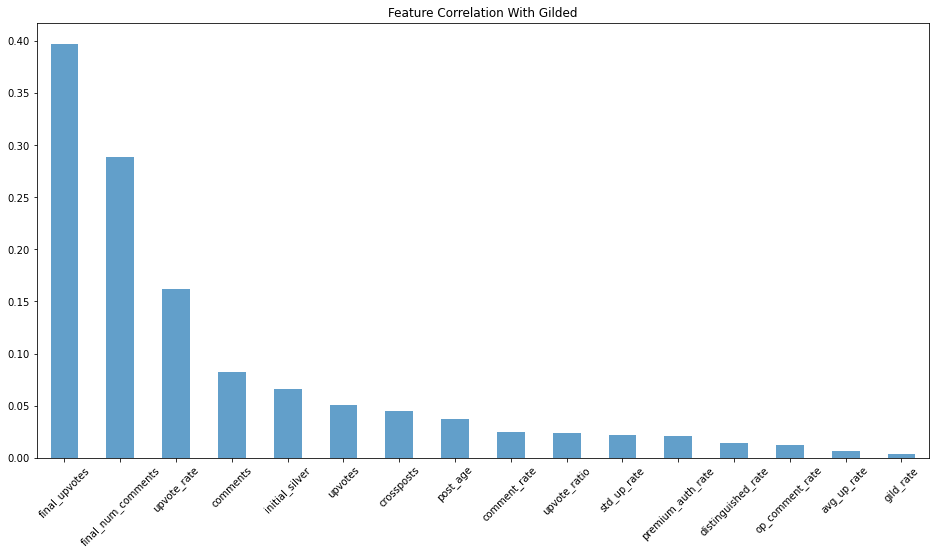

In [8]:
plt.figure(figsize=(16, 8))
num.corrwith(df['gilded'], axis = 0).sort_values(ascending = False).plot.bar(alpha = 0.7)
plt.title('Feature Correlation With Gilded')
plt.xticks(rotation=45)
plt.show()

Clearly gilded posts are most strongly correlated with the final total number of upvotes and comments. This supports the hypothesis that gilding can be used as an indicator of post success.

In terms of predictive power, the upvote rate (number of upvotes per minute of post age) is the most strongly correlated with gilding. 

Total number of comments (when the post was scraped) is also a useful indicator, but this value is intrinsically tied with post age (obviously older posts will have more time to accumulate comments), so I believe comment_rate is a better overall feature.

#### How old are posts when they are scraped from Reddit?

It depends on the sorting. The data collection pipeline pulls posts sorted both by "new" and by "rising," using Reddit's definition of the two terms. 

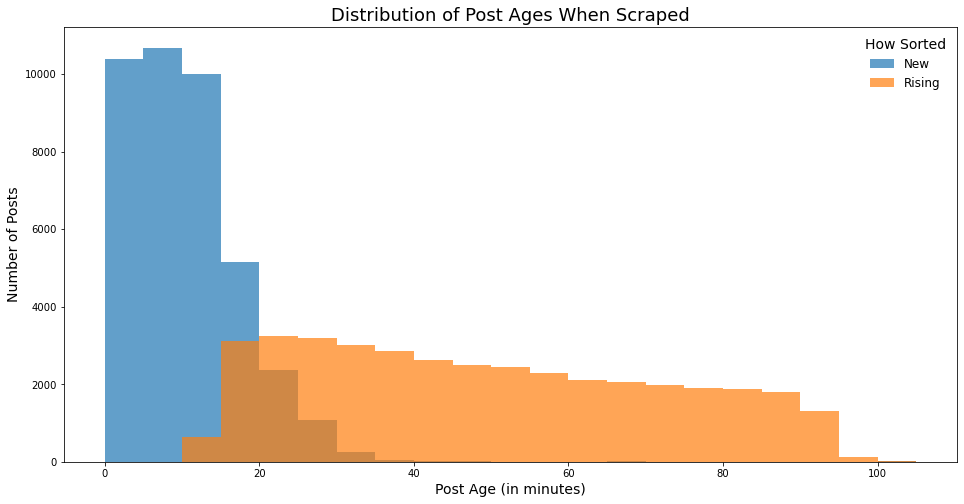

In [9]:
bins = np.arange(0, 110, 5)

plt.figure(figsize=(16, 8))
plt.hist(df[ (df['post_age'] < 115) & (df['how_sorted'] == 'new') ]['post_age'],
         alpha = 0.7,
         bins = bins,
         label = 'New'
        )
plt.hist(df[ (df['post_age'] < 115) & (df['how_sorted'] == 'rising') ]['post_age'],
         alpha = 0.7,
         bins = bins,
         label = 'Rising'
        )
plt.legend(loc='upper right',
           title = 'How Sorted',
           frameon = False,
           fontsize = 12,
           title_fontsize = 14
          )
plt.xlabel('Post Age (in minutes)', fontsize = 14)
plt.ylabel('Number of Posts', fontsize = 14)
plt.title('Distribution of Post Ages When Scraped', fontsize = 18)
plt.show()

It appears that Reddit tends to cap "Rising" posts at about 95 minutes, and most "New" posts are less than 20 minutes old. It is unclear how Reddit's API serves "New" posts across multiple subreddits, for example would a 10 minute-old post from a relatively inactive subreddit be served prior to a 5 minute-old post in an extremely active subreddit - the prior being more-new relative to the subreddit it is posted in? 

#### Upvotes, comments, and time

How does the gilding frequency (comparable to conversion rate in a more typical business setting) depend on the total number of upvotes and comments (both measured at the time of scraping), and how do they interact with time?

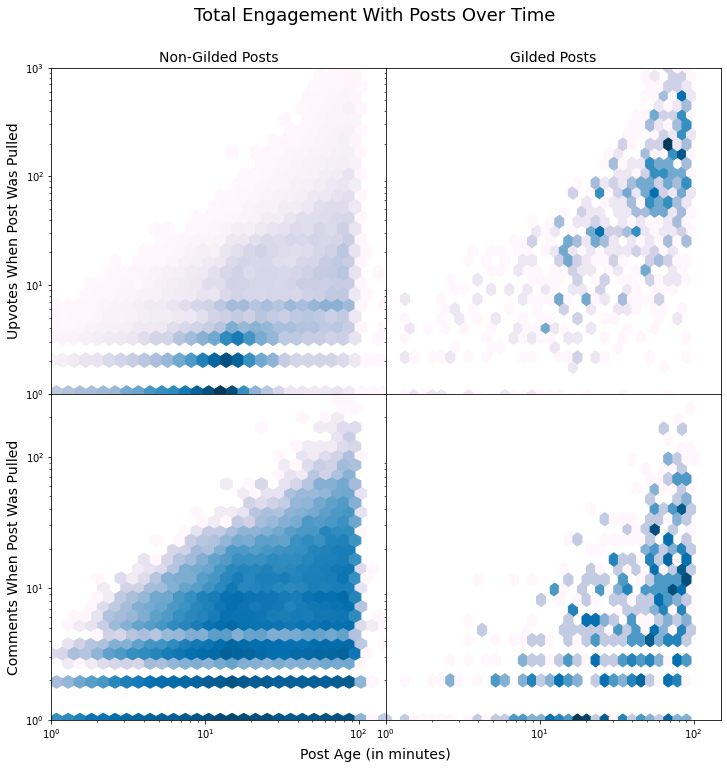

In [10]:
gilded_mask = df['gilded'] == 1

age_gild = df[gilded_mask]['post_age']
age_no_gild = df[~gilded_mask]['post_age']

upv_gild = [x+0.1 if x == 0 else x for x in df[gilded_mask]['upvotes']]
comm_gild = [x+0.1 if x == 0 else x for x in df[gilded_mask]['comments']]

upv_no_gild = [x+0.1 if x == 0 else x for x in df[~gilded_mask]['upvotes']]
comm_no_gild = [x+0.1 if x == 0 else x for x in df[~gilded_mask]['comments']]

grid_size = 50
cmap = 'PuBu'

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize = (12,12))
plt.subplots_adjust(wspace=0, hspace=0)


ax1.hexbin(age_no_gild, upv_no_gild, xscale = 'log', yscale = 'log', gridsize = grid_size, cmap = cmap, mincnt=1)
ax1.set_title('Non-Gilded Posts', fontsize = 14)
ax1.set_ylabel('Upvotes When Post Was Pulled', fontsize = 14)
ax2.hexbin(age_gild, upv_gild, xscale = 'log', yscale = 'log', gridsize = grid_size, cmap = cmap, mincnt=1)
ax2.set_title('Gilded Posts', fontsize = 14)

ax1.set_xlim([1, 150])
ax1.set_ylim([1,1000])
ax2.set_xlim([1, 150])
ax2.set_ylim([1,1000])

ax1.set_xticks([])
ax2.set_xticks([])
ax2.set_yticks([])

ax3.hexbin(age_no_gild, comm_no_gild, xscale = 'log', yscale = 'log', bins = 'log', gridsize = grid_size, cmap = cmap, mincnt=1)
ax3.set_ylabel('Comments When Post Was Pulled', fontsize = 14)
ax4.hexbin(age_gild, comm_gild, xscale = 'log', yscale = 'log', bins = 'log', gridsize = grid_size, cmap = cmap, mincnt=1)

ax3.set_xlim([1, 150])
ax3.set_ylim([1,300])
ax4.set_xlim([1, 150])
ax4.set_ylim([1,300])

ax4.set_yticks([])

plt.suptitle('Total Engagement With Posts Over Time', fontsize = 18, y = 0.95)
fig.text(0.5, 0.08, 'Post Age (in minutes)', ha='center', fontsize = 14)
plt.show()

Unsurprisingly, the gilded posts tend to cluster towards higher number of upvotes - however there is a much-less-clear pattern visible in the "Comments" data.

Of course posts that are older have more opportunities to accumulate upvotes and comments. Below both features are normalized by the post's age in order to control for this issue.

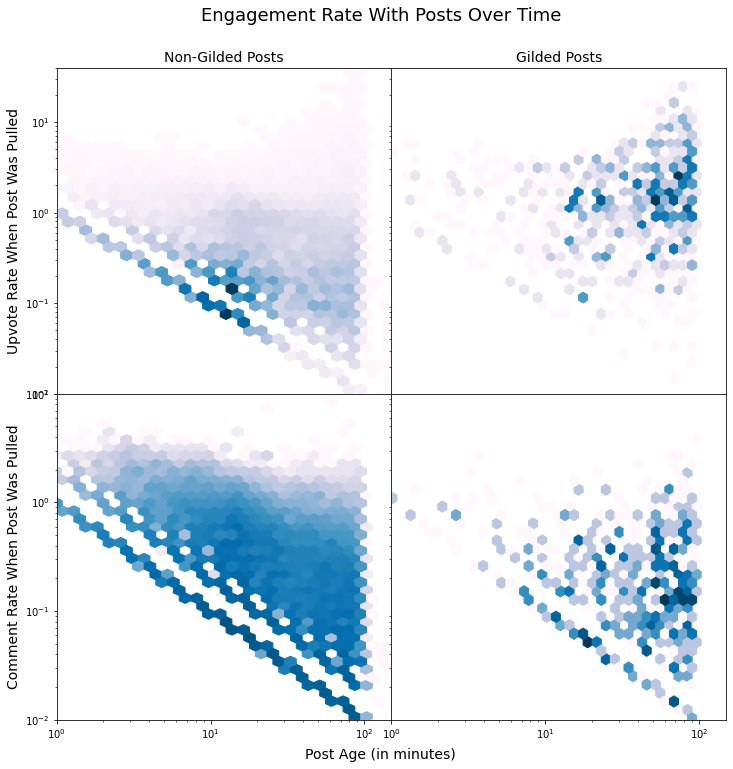

In [11]:
gilded_mask = df['gilded'] == 1

age_gild = df[gilded_mask]['post_age']
age_no_gild = df[~gilded_mask]['post_age']

upv_gild = [x+0.001 if x == 0 else x for x in df[gilded_mask]['upvote_rate']]
comm_gild = [x+0.001 if x == 0 else x for x in df[gilded_mask]['comment_rate']]

upv_no_gild = [x+0.001 if x == 0 else x for x in df[~gilded_mask]['upvote_rate']]
comm_no_gild = [x+0.001 if x == 0 else x for x in df[~gilded_mask]['comment_rate']]

grid_size = 50
cmap = 'PuBu'

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize = (12,12))
plt.subplots_adjust(wspace=0, hspace=0)


ax1.hexbin(age_no_gild, upv_no_gild, xscale = 'log', yscale = 'log', gridsize = grid_size, cmap = cmap, mincnt=1)
ax1.set_title('Non-Gilded Posts', fontsize = 14)
ax1.set_ylabel('Upvote Rate When Post Was Pulled', fontsize = 14)
ax2.hexbin(age_gild, upv_gild, xscale = 'log', yscale = 'log', gridsize = grid_size, cmap = cmap, mincnt=1)
ax2.set_title('Gilded Posts', fontsize = 14)

ax1.set_xlim([1, 150])
ax1.set_ylim([0.01,40])
ax2.set_xlim([1, 150])
ax2.set_ylim([0.01,40])

ax1.set_xticks([])
ax2.set_xticks([])
ax2.set_yticks([])

ax3.hexbin(age_no_gild, comm_no_gild, xscale = 'log', yscale = 'log', bins = 'log', gridsize = grid_size, cmap = cmap, mincnt=1)
ax3.set_ylabel('Comment Rate When Post Was Pulled', fontsize = 14)
ax4.hexbin(age_gild, comm_gild, xscale = 'log', yscale = 'log', bins = 'log', gridsize = grid_size, cmap = cmap, mincnt=1)

ax3.set_xlim([1, 150])
ax3.set_ylim([0.01,10])
ax4.set_xlim([1, 150])
ax4.set_ylim([0.01,10])

ax4.set_yticks([])

plt.suptitle('Engagement Rate With Posts Over Time', fontsize = 18, y = 0.95)
fig.text(0.5, 0.08, 'Post Age (in minutes)', ha='center', fontsize = 14)
plt.show()

At first glance there seems to be a stronger separation between non-gilded and gilded posts when considering upvote-rate as compared to total upvotes. Once again, however, the gilded posts are distributed somewhat uniformly across all values of upvote rate and tend to overlap heavily with the non-gilded posts.

It would be intersing to attempt to fit a classification algorithm (e.g. nearest neighbors) to the above data using their log-values (as shown in plots) in order to see which features are most informative. This could be a way to engineer one or more new features which is highly non-linear in the original data.

#### Upvote and Comment rates on their own

Consider the normalized *upvote_rate* and *comment_rate* features on their own.

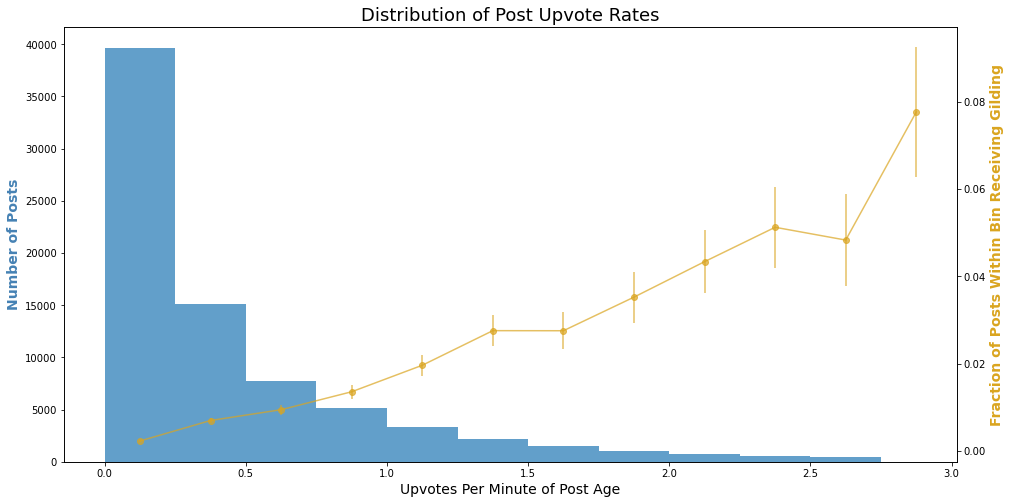

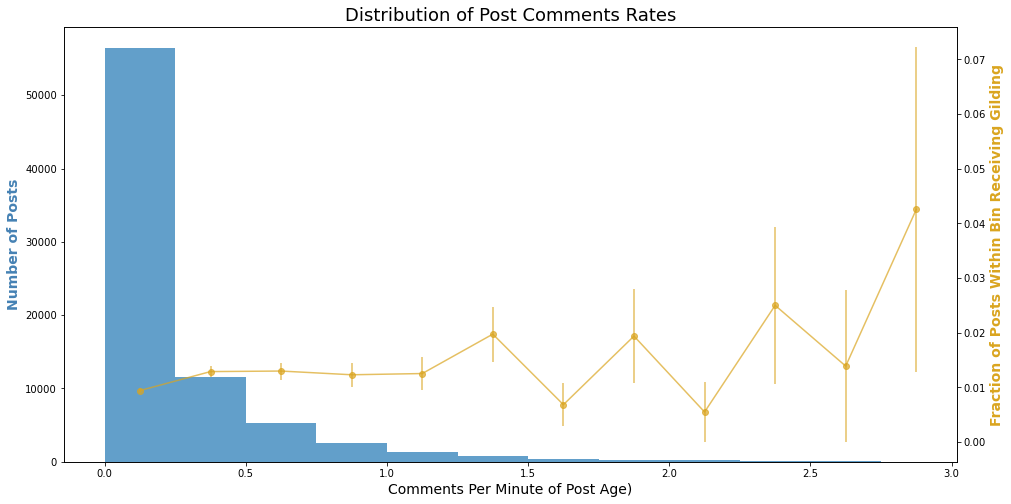

In [12]:
step_size = 0.25
bins = np.arange(0, 3, step_size)
bin_centers = [lower_bound + step_size/2 for lower_bound in bins]


def build_gild_fraction_by_feature_rates(df, bins, step_size, feature = 'Upvotes'):
    
    if feature == 'Upvotes':
        feat_name = 'upvote_rate'
    elif feature == 'Comments':
        feat_name = 'comment_rate'
    else:
        raise Exception('Wrong feature.')
    
    gild_fractions = []
    gild_variances = []
    for lower_bound in bins:
        upper_bound = lower_bound + step_size
        rate_mask = (df[feat_name] >= lower_bound) & (df[feat_name] < upper_bound)
        #gild_mask = df['gilded'] == 1
        
        df_in_bin = df[rate_mask]
        num_in_bin = df_in_bin.shape[0]
        
        gild_fraction_in_bin = df_in_bin['gilded'].mean()
        gild_variance_in_bin = df_in_bin['gilded'].std()/np.sqrt(num_in_bin)
        
        gild_fractions.append(gild_fraction_in_bin)
        gild_variances.append(gild_variance_in_bin)
        
    return gild_fractions, gild_variances


# Look at Upvotes
fig, (ax1) = plt.subplots(1,1, figsize = (16,8))
gild_data_by_upvote_rate = build_gild_fraction_by_feature_rates(df = df,
                                                                bins = bins,
                                                                step_size = step_size,
                                                                feature = 'Upvotes'
                                                               )
ax1.hist(df['upvote_rate'],
         label = 'Upvote Rate',
         alpha = 0.7,
         bins = bins,
        )
ax12 = ax1.twinx()
ax12.errorbar(bin_centers,
              gild_data_by_upvote_rate[0],
              yerr = gild_data_by_upvote_rate[1],
              marker = 'o',
              color = 'goldenrod',
              alpha = 0.7
             )
ax1.set_xlabel('Upvotes Per Minute of Post Age', fontsize = 14)
ax1.set_ylabel('Number of Posts', fontsize = 14, color = 'steelblue', fontweight = 'bold')
ax12.set_ylabel('Fraction of Posts Within Bin Receiving Gilding', fontsize = 14, color = 'goldenrod', fontweight = 'bold')
plt.title('Distribution of Post Upvote Rates', fontsize = 18)

plt.show()



# Now look at Comments
fig, (ax1) = plt.subplots(1,1, figsize = (16,8))

gild_data_by_comment_rate = build_gild_fraction_by_feature_rates(df = df,
                                                                 bins = bins,
                                                                 step_size = step_size,
                                                                 feature = 'Comments'
                                                                )
ax1.hist(df['comment_rate'],
         label = 'Comment Rate',
         alpha = 0.7,
         bins = bins,
        )
ax12 = ax1.twinx()
ax12.errorbar(bin_centers,
              gild_data_by_comment_rate[0],
              yerr = gild_data_by_comment_rate[1],
              marker = 'o',
              color = 'goldenrod',
              alpha = 0.7
             )
ax1.set_xlabel('Comments Per Minute of Post Age)', fontsize = 14)
ax1.set_ylabel('Number of Posts', fontsize = 14, color = 'steelblue', fontweight = 'bold')
ax12.set_ylabel('Fraction of Posts Within Bin Receiving Gilding', fontsize = 14, color = 'goldenrod', fontweight = 'bold')
plt.title('Distribution of Post Comments Rates', fontsize = 18)

plt.show()

Most posts have fewer than one comment or post every 4 minutes. However, as seen from the top plot, the upvote rate seems to be a much better predictor of gilding than the comment rate is.

In [13]:
def conversion_rate_by_bin(feature, target):
    
    feature_vals = feature.unique()
    
    fraction_of_positive_targets = []
    for val in feature_vals:
        value_mask = (feature == val)
        target_mask = (target == 1)
        
        feature_equals_val = feature[value_mask]
        feature_equals_val_target_mask = featu
        
        
        
        feature_equals_val_and_positive_target = feature[value_mask & target_mask]
        
        fraction_of_vals_positive_target = len(feature_equals_val_and_positive_target)/len(feature_equals_val)
        fraction_of_positive_targets.append(fraction_of_vals_positive_target)
    
    
    return

#### Look at the distributions of the remaining numerical features

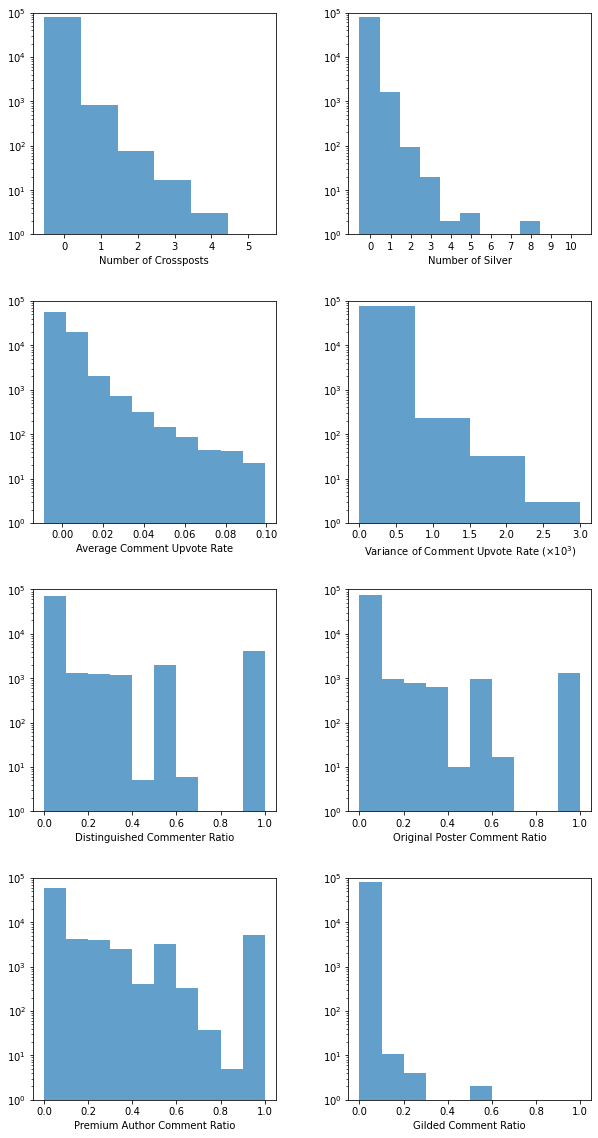

In [14]:
def build_bins(n_max):
    return [x-0.5 for x in np.linspace(0,n_max+1,n_max+2)]
def build_ticks(n_max):
    return [x+0.05 for x in np.linspace(0,n_max,n_max+1)]
def build_tick_labels(n_max):
    return [int(x) for x in np.linspace(0,n_max,n_max+1)]

alpha = 0.7

fig, axes = plt.subplots(4,2, figsize = (10,20))

for ax_line in axes:
    for ax in ax_line:
        ax.set_yscale('log')
        ax.set_ylim([1,10**5])

((ax00, ax01), (ax10, ax11), (ax20,ax21), (ax30, ax31)) = axes
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Crossposts
n00 = 5
ax00.hist(df['crossposts'], alpha = alpha, bins = build_bins(n00))
ax00.set_xticks(build_ticks(n00))
ax00.set_xticklabels(build_tick_labels(n00))
ax00.set_xlabel('Number of Crossposts')

# Silver
n01 = 10
ax01.hist(df['initial_silver'], alpha = alpha, bins = build_bins(n01))
ax01.set_xticks(build_ticks(n01))
ax01.set_xticklabels(build_tick_labels(n01))
ax01.set_xlabel('Number of Silver')

# Comment upvote rate average
ax10.hist(df['avg_up_rate'], alpha = alpha,)
ax10.set_xlabel('Average Comment Upvote Rate')

# Comment upvote rate variance
ax11.hist(df['std_up_rate']*1000, alpha = alpha, bins = np.linspace(0,3,5))
ax11.set_xlabel(r'Variance of Comment Upvote Rate ($\times 10^{3}$)')

# Distinguished commenter
ax20.hist(df['distinguished_rate'], alpha = alpha)
ax20.set_xlabel('Distinguished Commenter Ratio')

# Original Poster commenter
ax21.hist(df['op_comment_rate'], alpha = alpha)
ax21.set_xlabel('Original Poster Comment Ratio')

# Premium commenter
ax30.hist(df['premium_auth_rate'], alpha = alpha)
ax30.set_xlabel('Premium Author Comment Ratio')

# Comment gildings
ax31.hist(df['gild_rate'], alpha = alpha)
ax31.set_xlabel('Gilded Comment Ratio')

plt.show()

### Now look at categorical data

#### Build a tool to easily analyze all categorical variables

In [15]:
class Categ_Analysis:
    
    def __init__(self, feature_column, target_column = None, ordinal = False):
        
        if not ordinal:
            self.feature_column = feature_column
        else:
            self.feature_column = feature_column.sort_values(ascending = True)
        
        self.target_column = target_column
        self.target_frac = False
        self.hist_dict = False
        self.target_nums = False

    def get_fracs(self, feat_values, hist_dict):
        
        target_frac = []
        target_nums = []
        for val in feat_values:
            target_num_in_bin = self.target_column[hist_dict[val]['bool_mask']].sum()
            target_frac_in_bin = target_num_in_bin/hist_dict[val]['num_in_bin']

            target_frac.append(target_frac_in_bin)
            target_nums.append(target_num_in_bin)
            
        return target_frac, target_nums
    
    
      
    def build_hist_dict(self, feat_values):

        hist_dict = {}
        for val in feat_values:
            val_bool_mask = self.feature_column == val
            num_in_bin = val_bool_mask.sum()
            hist_dict[val] = {}
            hist_dict[val]['num_in_bin'] = num_in_bin
            hist_dict[val]['bool_mask'] = val_bool_mask 
        
        return hist_dict
        

               
    def avg_list(self, L):
        return sum(L)/len(L)
    
    
     
    def variance_list(self, L):
        
        N = len(L)
        mean = self.avg_list(L)
        diff_means_squared = [(x - mean)**2 for x in L]
        std_dev = np.sqrt(sum(diff_means_squared)/N)
        
        stdem = std_dev/np.sqrt(N)
        
        return stdem
    
    
    
    def make_plot(self, title, xlabel, bin_names = False, conversion_fracs = False, error_bars = False, figsize = (10,10)):
        
        if conversion_fracs:
            if (self.target_column is None):
                raise Exception('Must supply a target column to get conversion fractions.')
        
        
        # Make distribution plt
        fig, ax = plt.subplots(1,1, figsize = figsize)
        
        feat_values = self.feature_column.unique()
        self.hist_dict = self.build_hist_dict(feat_values)
        
        num_vals = len(feat_values)
        bar_x_locs = np.arange(0, num_vals)
        heights = [val_dict['num_in_bin'] for val_dict in self.hist_dict.values()]
        
        ax.bar(bar_x_locs, heights, alpha = 0.7)
        ax.set_xticks(bar_x_locs)
        ax.set_xticklabels(self.hist_dict.keys())
        ax.set_ylabel('Total Number of Instances in Bin', fontsize = 14)
        
        ax.set_xlabel(xlabel, fontsize = 14)
        ax.set_title(title, fontsize = 18)
        
        if bin_names:
            ax.set_xticklabels(bin_names)
        
        # Build conversion rates       
        if conversion_fracs:         
            self.target_frac, self.target_nums = self.get_fracs(feat_values, self.hist_dict)
            frac_max = max(self.target_frac)
            legend_string = 'Fraction of Instances Equal To Target Value'
            
            ax2 = ax.twinx()
            ax2.plot(bar_x_locs, self.target_frac, 'ok', alpha = 0.7, label = legend_string)
            ax2.set_ylim([0,1.2*frac_max])
            ax2.legend(loc = 'upper right',)
           
        return fig        
             
    
    
    
    def get_chisq(self):
        from scipy.stats.distributions import chi2
        
        if not self.hist_dict:
            feat_values = self.feature_column.unique()
            self.hist_dict = self.build_hist_dict(feat_values)
        
        if not self.target_frac:
            feat_values = self.feature_column.unique()            
            self.target_frac, self.target_nums = self.get_fracs(feat_values, self.hist_dict)     
        
        mean_target_frac = self.target_column.mean()
        
        expected = [mean_target_frac*value_dict['num_in_bin'] for value_dict in self.hist_dict.values()]
        
        observed = self.target_nums

        chi_squared = 0
        for idx, _ in enumerate(self.target_frac):
            chi_squared += (observed[idx] - expected[idx])**2/expected[idx]
        
        DF = len(observed) - 1
        
        probability = chi2.sf(chi_squared, DF)

        return chi_squared, probability

#### P-values

All the below features have p-values assigned to them. These p-values are all assuming that the null-hypothesis is:
> ##### Null hypothesis: The relative fraction of gildings is constant across all values within a particular feature.

Taking 0.05 as our cutoff for significance, any p-value less than 0.05 indicates that the corresponding feature may be useful for predicting whether or not a particular post will be gilded. 

For example, looking at the plot directly below the feature *post_hour* has a p-value on the order of $10^{-13}$ which indicates that there is strong statistical evidence that the likelihood of a post being gilded changes in a dramatic and somewhat predictible fashion over the course of a day.

On the other hand, when considering the dependence of gildings on the day of the week the p-value is about 0.1 - above the stated threshold. This indicates that there is not strong statistical evidence that a post is more likely to be gilded on one vs. another. However, by inspection of the plot, it is clear that posts made on Fridays enjoy a roughly 1.3% chance of being gilded compared to about 0.9% on Mondays. As the number of posts collected increases this may or may not continue to hold - as will be evidenced by the shift in p-value.

Chi-squared is: 108.41
P-value: 4.8e-13


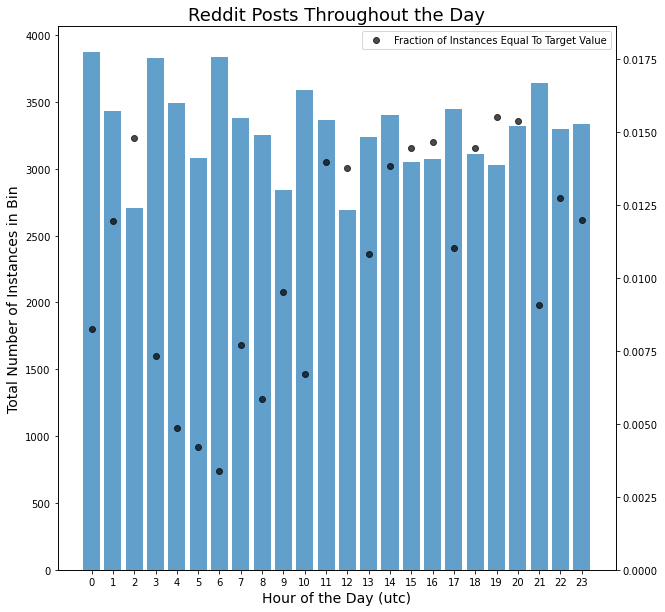

In [16]:
time = Categ_Analysis(df['post_hour'], target_column = df['gilded'], ordinal = True)
time.make_plot(xlabel = 'Hour of the Day (utc)', title = 'Reddit Posts Throughout the Day', conversion_fracs = True).show()
chi_squared, proba = time.get_chisq()
print('Chi-squared is: {:.2f}'.format(chi_squared) )
print('P-value: {:.1e}'.format(proba))

Chi-squared is: 10.43
P-value: 0.108


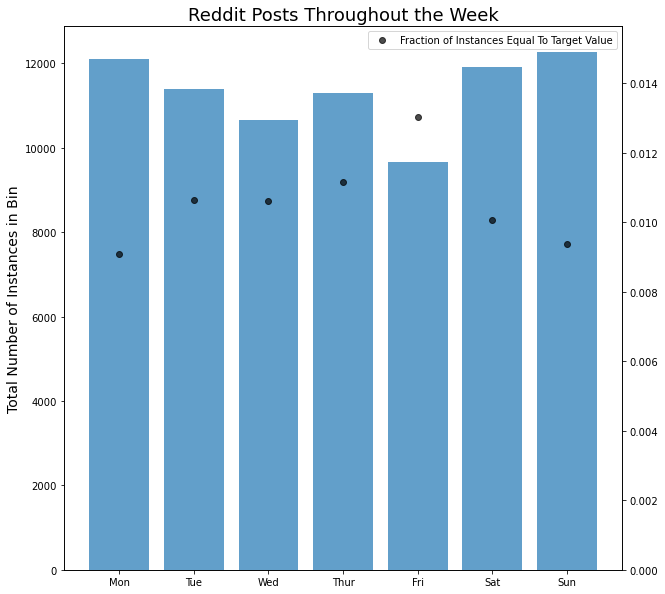

In [17]:
weekdays = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']

time = Categ_Analysis(df['weekday'], target_column = df['gilded'], ordinal = True)
time.make_plot(xlabel = '', bin_names = weekdays,title = 'Reddit Posts Throughout the Week', conversion_fracs = True).show()
chi_squared, proba = time.get_chisq()
print('Chi-squared is: {:.2f}'.format(chi_squared) )
print('P-value: {:.3f}'.format(proba))

Chi-squared is: 1104.06
P-value: 4.2e-195


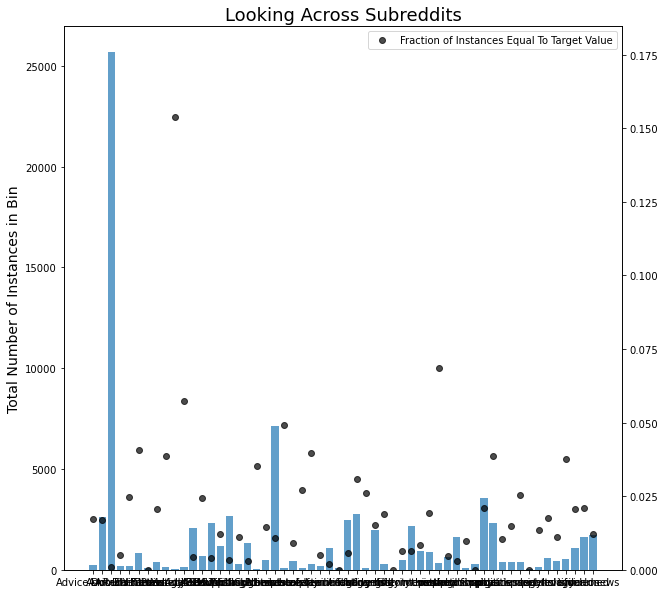

In [20]:
time = Categ_Analysis(df['subreddit'], target_column = df['gilded'], ordinal = True)
time.make_plot(xlabel = '', title = 'Looking Across Subreddits', conversion_fracs = True).show()



chi_squared, proba = time.get_chisq()
print('Chi-squared is: {:.2f}'.format(chi_squared) )
print('P-value: {:.1e}'.format(proba))

Chi-squared is: 8.67
P-value: 0.003


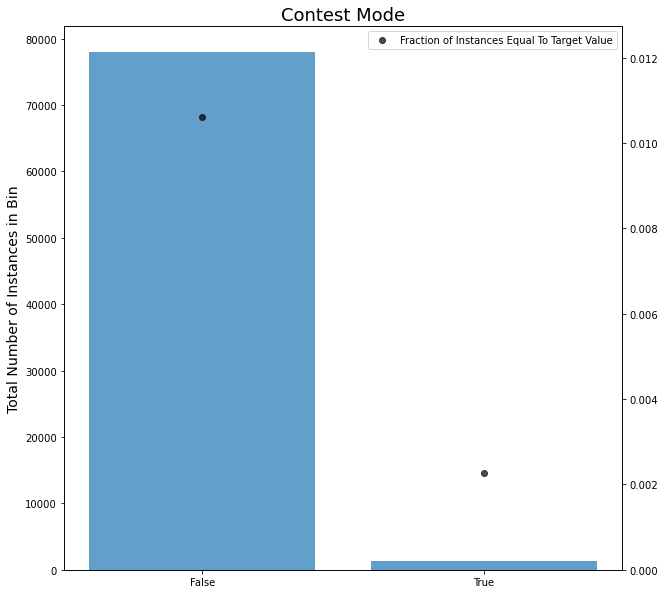

In [21]:
time = Categ_Analysis(df['contest_mode'], target_column = df['gilded'], ordinal = True)
time.make_plot(xlabel = '', title = 'Contest Mode', conversion_fracs = True).show()
chi_squared, proba = time.get_chisq()
print('Chi-squared is: {:.2f}'.format(chi_squared) )
print('P-value: {:.3f}'.format(proba))

Chi-squared is: 0.84
P-value: 0.360


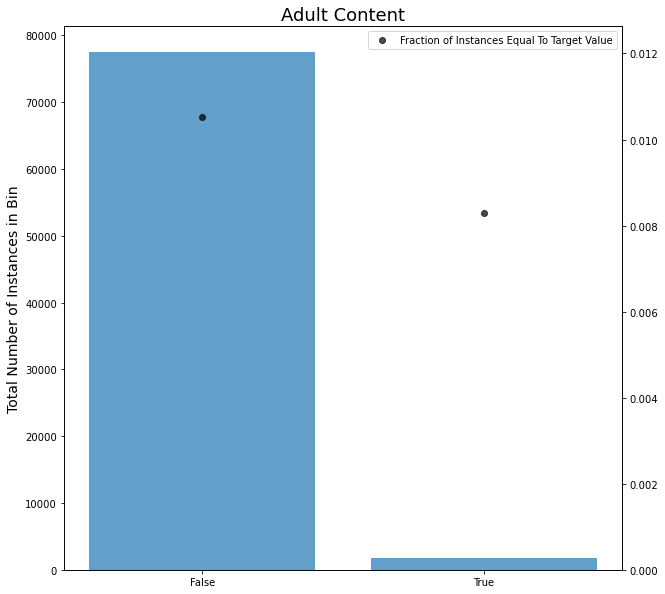

In [22]:
time = Categ_Analysis(df['adult_content'], target_column = df['gilded'], ordinal = True)
time.make_plot(xlabel = '', title = 'Adult Content', conversion_fracs = True).show()
chi_squared, proba = time.get_chisq()
print('Chi-squared is: {:.2f}'.format(chi_squared) )
print('P-value: {:.3f}'.format(proba))

Chi-squared is: 9.85
P-value: 0.0017


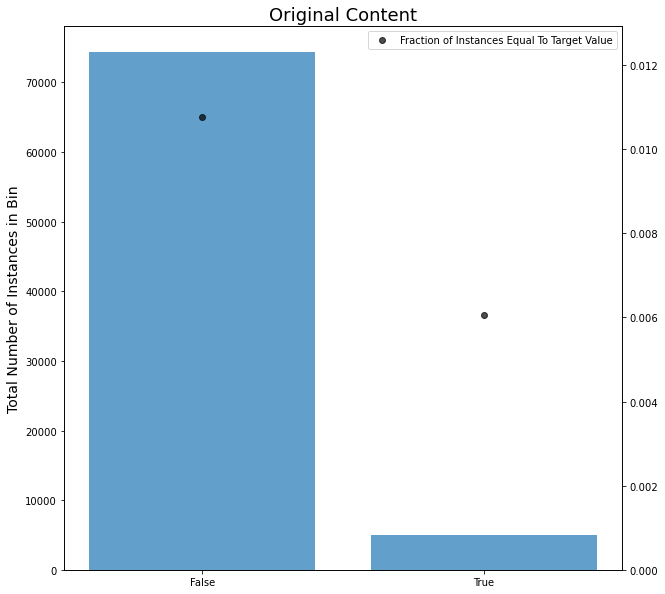

In [23]:
time = Categ_Analysis(df['oc'], target_column = df['gilded'], ordinal = True)
time.make_plot(xlabel = '', title = 'Original Content', conversion_fracs = True).show()
chi_squared, proba = time.get_chisq()
print('Chi-squared is: {:.2f}'.format(chi_squared) )
print('P-value: {:.4f}'.format(proba))

Chi-squared is: 129.13
P-value: 6.4e-30


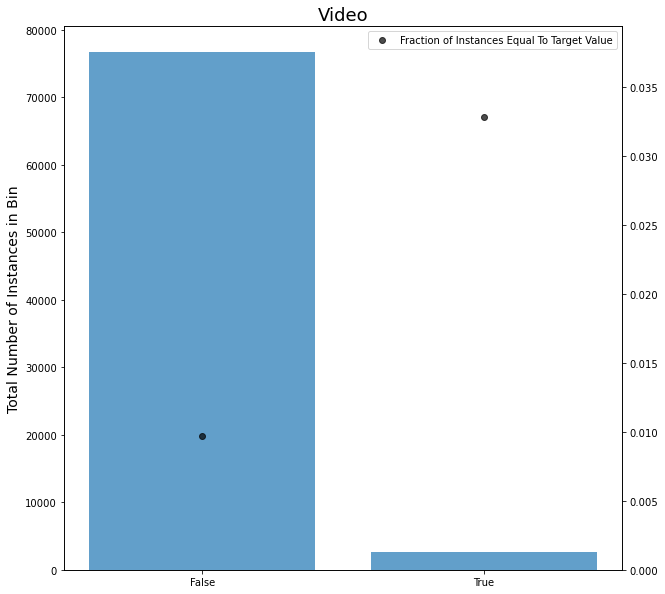

In [24]:
time = Categ_Analysis(df['video'], target_column = df['gilded'], ordinal = True)
time.make_plot(xlabel = '', title = 'Video', conversion_fracs = True).show()
chi_squared, proba = time.get_chisq()
print('Chi-squared is: {:.2f}'.format(chi_squared) )
print('P-value: {:.1e}'.format(proba))

Chi-squared is: 116.96
P-value: 2.9e-27


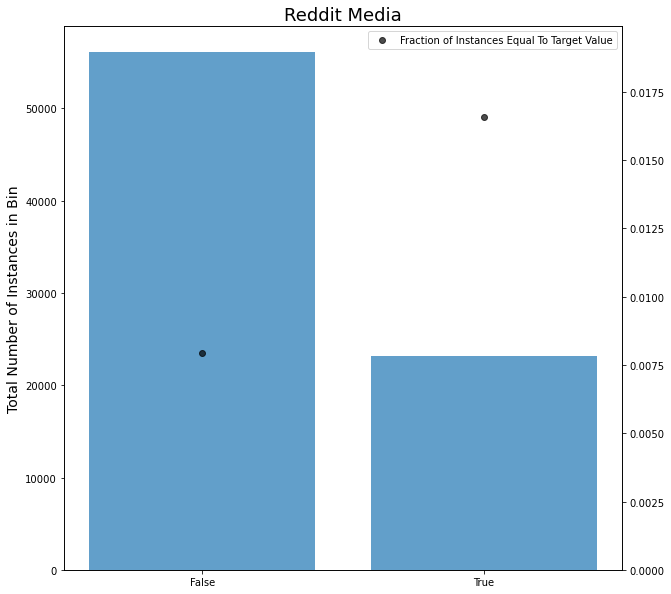

In [25]:
time = Categ_Analysis(df['reddit_media'], target_column = df['gilded'], ordinal = True)
time.make_plot(xlabel = '', title = 'Reddit Media', conversion_fracs = True).show()
chi_squared, proba = time.get_chisq()
print('Chi-squared is: {:.2f}'.format(chi_squared) )
print('P-value: {:.1e}'.format(proba))

Chi-squared is: 350.15
P-value: 3.9e-78


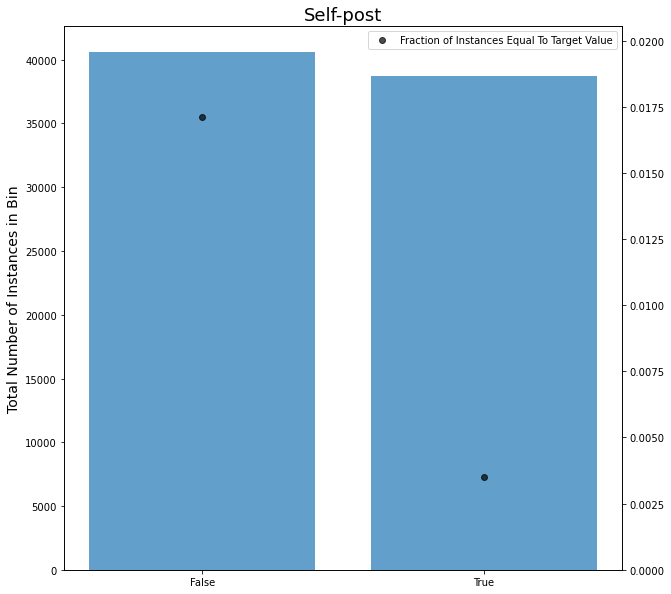

In [26]:
time = Categ_Analysis(df['selfpost'], target_column = df['gilded'], ordinal = True)
time.make_plot(xlabel = '', title = 'Self-post', conversion_fracs = True).show()
chi_squared, proba = time.get_chisq()
print('Chi-squared is: {:.2f}'.format(chi_squared) )
print('P-value: {:.1e}'.format(proba))

Chi-squared is: 14.40
P-value: 1.5e-04


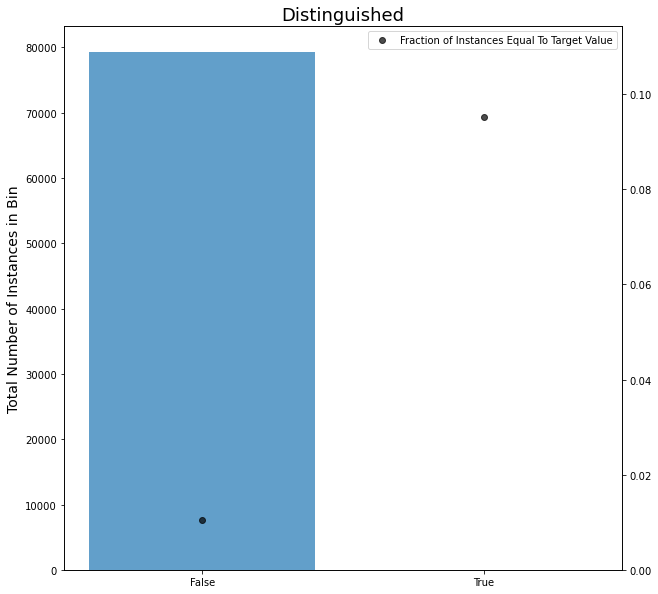

In [27]:
time = Categ_Analysis(df['distinguished'], target_column = df['gilded'], ordinal = True)
time.make_plot(xlabel = '', title = 'Distinguished', conversion_fracs = True).show()
chi_squared, proba = time.get_chisq()
print('Chi-squared is: {:.2f}'.format(chi_squared) )
print('P-value: {:.1e}'.format(proba))

Chi-squared is: 161.91
P-value: 5.7e-34


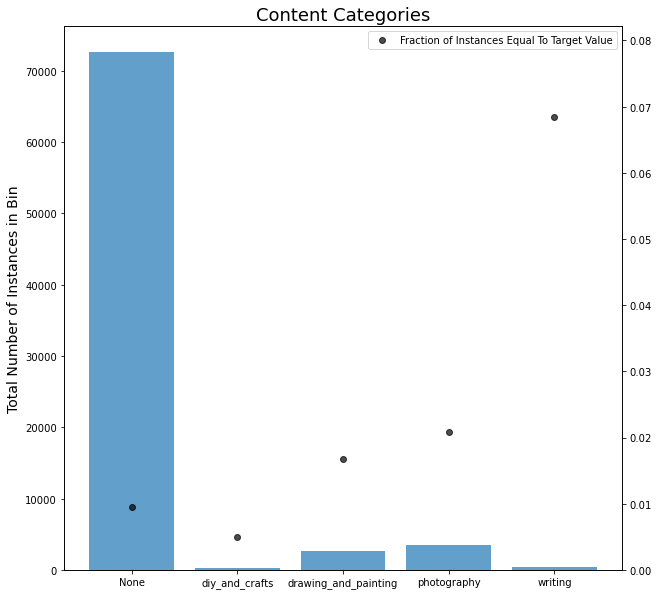

In [28]:
time = Categ_Analysis(df['content_categories'], target_column = df['gilded'], ordinal = True)
time.make_plot(xlabel = '', title = 'Content Categories', conversion_fracs = True).show()
chi_squared, proba = time.get_chisq()
print('Chi-squared is: {:.2f}'.format(chi_squared) )
print('P-value: {:.1e}'.format(proba))

#### Another look at gildings throughout the day

When comparing the relative fraction of all-posts and gilded-posts throughout the day the pattern becomes more evident.

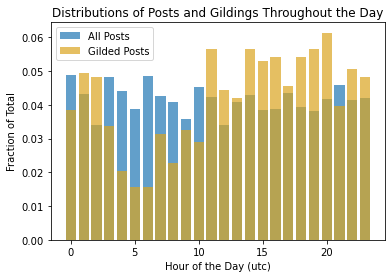

In [30]:
def build_fraction_of_all_posts_by_hour(df):
    
    n = df.shape[0]
    posts_each_hour = df.groupby('post_hour').count().iloc[:,0]
    fraction_of_posts_by_hour = posts_each_hour/n
    
    return fraction_of_posts_by_hour

def build_fraction_of_all_gilds_by_hour(df):
    
    gild_mask = df['gilded'] == 1
    total_num_gildings = df[gild_mask].shape[0]
    
    number_gilded_posts_by_hour = df[gild_mask].groupby('post_hour').count().iloc[:,0]
    fraction_of_all_gilds_by_hour = number_gilded_posts_by_hour/total_num_gildings
    
    return fraction_of_all_gilds_by_hour


fraction_of_all_posts_by_hour = build_fraction_of_all_posts_by_hour(df)
fraction_of_all_gilds_by_hour = build_fraction_of_all_gilds_by_hour(df)

plt.figure()
plt.bar(np.arange(24), fraction_of_all_posts_by_hour, alpha = 0.7, label = 'All Posts')
plt.bar(np.arange(24), fraction_of_all_gilds_by_hour, alpha = 0.7, color = 'goldenrod', label = 'Gilded Posts')
plt.legend(loc='upper left')
plt.title('Distributions of Posts and Gildings Throughout the Day')
plt.xlabel('Hour of the Day (utc)')
plt.ylabel('Fraction of Total')
plt.show()

#### Gilding likelihood across subreddits

Some subreddits are more likely to gild posts than others.

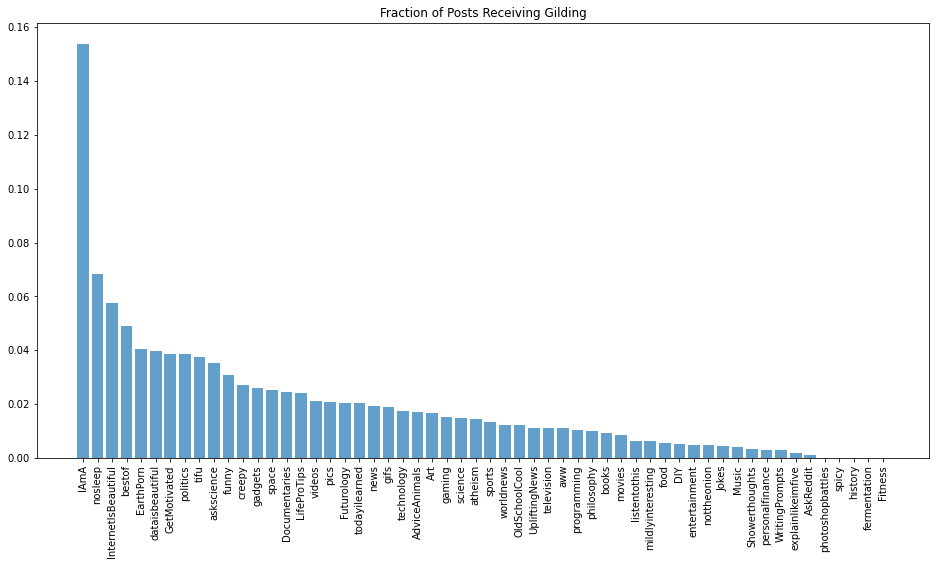

In [39]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def build_subreddit_gilded_ratios(df):
    
    ratios = []
    subs = list(df['subreddit'].unique())
    #subs.remove('blog')
    for subreddit in subs:
        subr_mask = df['subreddit'] == subreddit
        gilded_mask = df['gilded'] == 1
        
        subr_all = df[subr_mask]
        subr_gilded = df[(gilded_mask) & (subr_mask)]
        
        subr_ratio = subr_gilded.shape[0]/subr_all.shape[0]
        ratios.append(subr_ratio)
    
    sub_ratios = pd.DataFrame({'Subreddit': subs, 'Ratio': ratios}).sort_values('Ratio', ascending = False)
    
    return sub_ratios 

# Calculate the percentage of posts which received gilding in each bin.
subr_ratios = build_subreddit_gilded_ratios(df)

plt.figure(figsize=(16, 8))
plt.bar(x = subr_ratios['Subreddit'], height = subr_ratios['Ratio'], alpha = 0.7)
plt.xticks(rotation=90)
plt.title('Fraction of Posts Receiving Gilding')
plt.show()